In [1]:
import collections
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import AutoTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from datasets import Dataset, DatasetDict

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils import resample

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


In [2]:
import torch
torch.cuda.empty_cache() 

In [3]:
prose = {
    'Genesis',
    'Exodus',
    'Leviticus',
    'Numbers',
    'Deuteronomy',
    'Joshua',
    'Judges',
    '1_Samuel',
    '2_Samuel',
    '1_Kings',
    '2_Kings',
    'Ruth',
    'Esther',
    'Daniel',
    'Ezra',
    'Nehemiah',
    '1_Chronicles',
    '2_Chronicles'
        }

poetry = {
    'Psalms',
    'Job',
    'Proverbs',
    'Song_of_songs',
    'Ecclesiastes',
    'Lamentations'
}

jeremiah = {'Jeremiah'}

genre_dict = {}
for book in prose:
    genre_dict[book] = 'prose'
for book in poetry:
    genre_dict[book] = 'poetry'

genre_dict['Jeremiah'] = 'Jeremiah'

In [4]:
def make_n_grams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

def make_n_clause_dict(n):
    """
    Makes sequences of n clauses in the Hebrew Bible, based on a running window.
    """
    n_clause_dict = {}

    for bo in F.otype.s('book'):
        cl_n_grams = list(make_n_grams(L.d(bo, 'clause'), n))
        
        for cl_n_gram in cl_n_grams:
            ch = L.u(cl_n_gram[0], 'chapter')[0]
            book, chapter_number = T.sectionFromNode(ch) 

            if book not in genre_dict:
                continue
            
            words_n_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_n_gram])))
            
            heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_n_clause]).strip()
            sp_list = [F.pdp.v(w) for w in words_n_clause]
            n_clause_dict[(book, chapter_number, cl_n_gram)] = [book, chapter_number, cl_n_gram, heb_text, sp_list]

    return n_clause_dict

In [5]:
n_clause_dict = make_n_clause_dict(2)


In [6]:
def get_model_outputs(model, inputs):
    outputs = model(**inputs)
    return outputs

In [7]:
def split_evenly(l, n):
    len_ = len(l)
    split_size = len_ // n
    split_size = n if not split_size else split_size
    offsets = [i for i in range(0, len_, split_size)]
    return [l[offset:offset + split_size] for offset in offsets]

In [8]:
heb_texts = [text for _, _, _, text, _  in list(n_clause_dict.values())]
heb_texts_n = split_evenly(heb_texts, 5000)

In [9]:
len(heb_texts_n)

5158

In [10]:
def get_hidden_states(heb_texts_n, model, tokenizer):
    hidden_states_dict = collections.defaultdict(list)
    
    for idx, texts_chunk in enumerate(heb_texts_n):
        tokenized_inputs = tokenizer(texts_chunk, max_length=128, truncation=True, padding=True, return_tensors="pt")
        tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
        with torch.no_grad():
            outputs = model(**tokenized_inputs)
            for layer_nr in range(1, 13):
                hidden_states = outputs.hidden_states[-1 * layer_nr].cpu().numpy()
                hidden_states_dict[layer_nr].append(hidden_states)

    return hidden_states_dict

def calculate_mean_hidden_states(hidden_states):
    hidden_states_mean = []

    for hs in hidden_states:
        bi_clause_states= np.mean(hs, 1)
        hidden_states_mean.append(bi_clause_states)

    all_embeddings = np.concatenate(hidden_states_mean, axis=0)
    return all_embeddings

def make_genre_list(n_clause_dict, genre_dict):
    all_genres = []
    for book, _, _ in n_clause_dict.keys():
        if genre_dict.get(book) == 'prose':
            all_genres.append(0)
        elif genre_dict.get(book) == 'poetry':
            all_genres.append(1)
        elif genre_dict.get(book) == 'Jeremiah':
            all_genres.append(2)

    return all_genres

def split_prose_poetry_end_jer_embeddings(all_genres, all_embeddings):
    pr_po_idx = [idx for idx, value in enumerate(all_genres) if value != 2]
    pr_po_labels = np.array([value for idx, value in enumerate(all_genres) if value != 2])

    prose_poetry_embeddings = all_embeddings[pr_po_idx,:]
    jer_embeddings = np.delete(all_embeddings, pr_po_idx, axis=0)
    return prose_poetry_embeddings, pr_po_labels, jer_embeddings

def upsample_poetry(X_train, y_train):
    X_train = pd.DataFrame(X_train)
    X_train['label'] = y_train

    poetry = X_train[X_train.label == 1]
    prose = X_train[X_train.label == 0]

    poetry_upsample = resample(poetry,
             replace=True,
             n_samples=len(prose),
             random_state=42)

    all_upsampled = pd.concat([poetry_upsample, prose])

    X_train = all_upsampled.drop('label', axis=1)
    y_train = all_upsampled['label']
    return X_train, y_train

def train_rf_classifier(X_train, y_train):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    return rf

def make_predictions(classifier, data):
    return classifier.predict(data)

def calculate_accuracy(y_test, y_pred):
    return accuracy_score(y_test, y_pred)

In [12]:
model_names = [#'martijn75/berel_finetuned_on_shuffled_HB_5_epochs_general',
               #'martijn75/berel_finetuned_on_shuffled_HB_3_epochs_general',
               #'dicta-il/BEREL',
               'dicta-il/BEREL_2.0'
              ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

for model_name in model_names:
    print('Model:', model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = BertForMaskedLM.from_pretrained(model_name,
                                            output_hidden_states=True,
                                            output_attentions=True
                                           ).to(device)
    model.eval()

    print('Retrieving embeddings')
    hidden_states_dict = get_hidden_states(heb_texts_n, model, tokenizer)
    all_genres = make_genre_list(n_clause_dict, genre_dict)
    for layer_nr in range(1,6):
        mean_embeddings = calculate_mean_hidden_states(hidden_states_dict.get(layer_nr))
        print('Hidden layer nr:', layer_nr)
        
        prose_poetry_embeddings, pr_po_labels, jer_embeddings = split_prose_poetry_end_jer_embeddings(all_genres, mean_embeddings)
        print('Split in train test')
        X_train, X_test, y_train, y_test = train_test_split(prose_poetry_embeddings, pr_po_labels, test_size=0.2)
        X_train, y_train = upsample_poetry(X_train, y_train)

        print('Training classifier')
        classifier = train_rf_classifier(X_train, y_train)
        y_pred = make_predictions(classifier, X_test)
        accuracy = calculate_accuracy(y_test, y_pred)
        crosstable = pd.crosstab(y_test, y_pred)

        print(model_name, accuracy)
        print(crosstable)
        print()

    del model
    del classifier

Model: dicta-il/BEREL_2.0
Retrieving embeddings
Hidden layer nr: 1
Split in train test
Training classifier
dicta-il/BEREL_2.0 0.9205664092079358
col_0      0     1
row_0             
0      10025   316
1        733  2132

Hidden layer nr: 2
Split in train test
Training classifier
dicta-il/BEREL_2.0 0.9111767378464335
col_0     0     1
row_0            
0      9911   379
1       794  2122

Hidden layer nr: 3
Split in train test
Training classifier



KeyboardInterrupt



### PCA

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, FastICA, NMF, FactorAnalysis

In [38]:
random_state = 0
pca_pl = make_pipeline(
    StandardScaler(),
    PCA(n_components = 6,
        random_state = random_state)
)

In [39]:
pcs = pca_pl.fit_transform(all_embeddings)

In [40]:
pcs

array([[ 5.805668  ,  7.4769063 , -0.37346864, -3.7834842 , -1.8134729 ,
         0.2691132 ],
       [ 2.5853958 ,  8.627541  ,  3.0438182 , -6.4689946 ,  1.69838   ,
         3.3006716 ],
       [ 7.0734625 ,  9.259462  ,  1.7980791 , -4.9935484 ,  2.1151292 ,
        -2.5766213 ],
       ...,
       [ 1.6764742 ,  3.9972677 , -0.06240111,  3.0160806 ,  1.6322224 ,
         7.8619742 ],
       [ 5.476207  ,  8.615441  , -4.272575  ,  7.209864  ,  0.9100232 ,
        -2.2984765 ],
       [-4.30871   ,  4.3895464 , -2.8330157 ,  6.2165866 , -6.667143  ,
        -7.2137094 ]], dtype=float32)

In [41]:
book = 'Genesis'
y = np.array([1 if bo == book else 0 for bo in all_genres])
y.sum()

5986

In [42]:
pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y



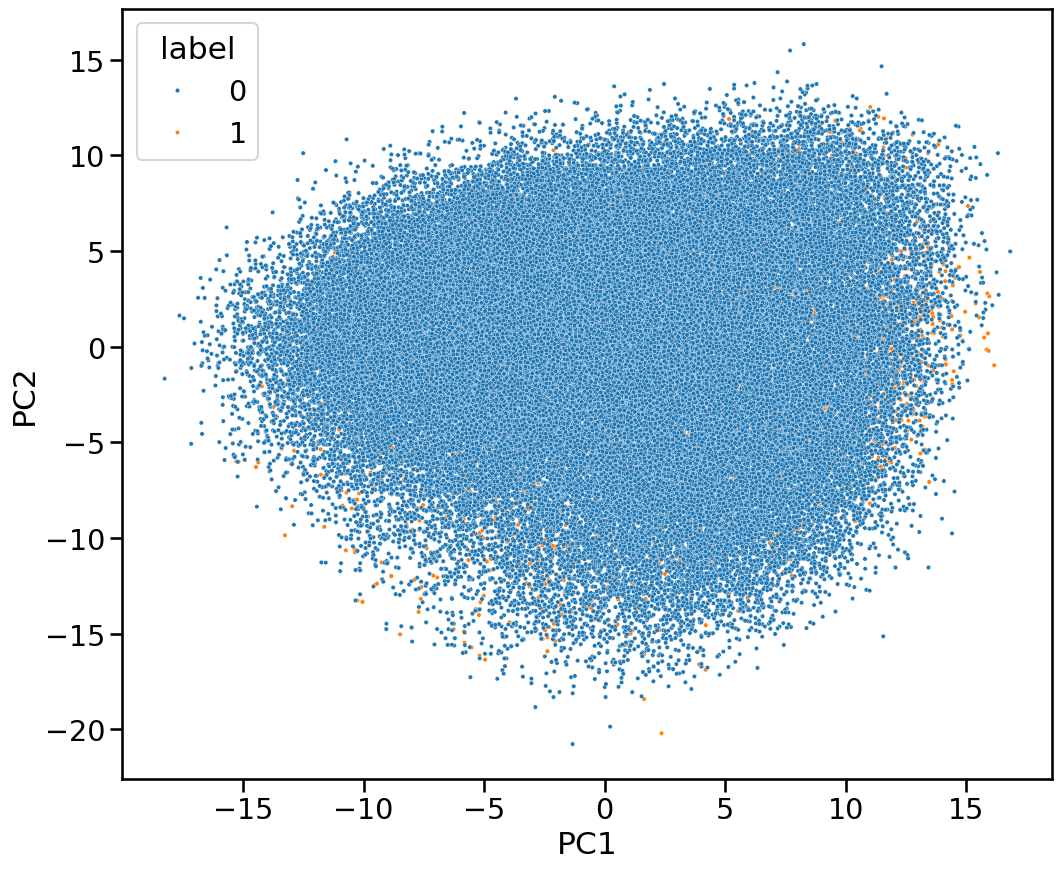

In [43]:
comp1 = 'PC1'
comp2 = 'PC2'


pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y
#pcs_df['book'] = _labels

plt.figure(figsize=(12,10))
with sns.plotting_context("talk",font_scale=1.25):
    sns.scatterplot(x=comp1, y=comp2,
                    data=pcs_df, 
                    hue="label",
                    s=10)
    plt.xlabel(comp1)
    plt.ylabel(comp2)
   
#plt.savefig("pca_chb_lbh_jer.png",
#                    format='png',dpi=150)

In [141]:
nm_ptc_clauses = []

# cl_types = {'AjCl', 'NmCl', 'Ptcp'}

for cl in F.otype.s('clause'):
    #cl_type = F.typ.v(cl)
    phrase_funcs = [F.function.v(phr) for phr in L.d(cl, 'phrase')]
    #if not ('PreC' in phrase_funcs and 'Subj' in phrase_funcs):
    #    continue
    #if cl_type in cl_types:
    heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in L.d(cl, 'word')]).strip()
    nm_ptc_clauses.append(heb_text)
    #print(heb_text)

len(nm_ptc_clauses)

88131

In [142]:
new_clauses = """
 דוד מלך
דוד היה מלך
היה דוד מלך

משׁה מלך
משׁה היה מלך
היה משׁה מלך

דוד בירושׁלים
דוד היה בירושׁלים
היה דוד בירושׁלים

דוד ישׁב בירושׁלים
ישׁב דוד בירושׁלים

דוד יושׁב בירושׁלים
יושׁב דוד בירושׁלים
 """

In [143]:
new_clauses = [cl.strip() for cl in new_clauses.split('\n') if cl.strip()]
new_clauses

['דוד מלך',
 'דוד היה מלך',
 'היה דוד מלך',
 'משׁה מלך',
 'משׁה היה מלך',
 'היה משׁה מלך',
 'דוד בירושׁלים',
 'דוד היה בירושׁלים',
 'היה דוד בירושׁלים',
 'דוד ישׁב בירושׁלים',
 'ישׁב דוד בירושׁלים',
 'דוד יושׁב בירושׁלים',
 'יושׁב דוד בירושׁלים']

In [144]:
all_nom_clauses = new_clauses + nm_ptc_clauses
all_nom_clauses_n = split_evenly(all_nom_clauses, 1000)

In [145]:
labels = new_clauses + len(nm_ptc_clauses)*['']
all_texts = new_clauses + nm_ptc_clauses

In [146]:
hidden_states = []

for text_chunks in all_nom_clauses_n:
    
    tokenized_inputs = tokenizer(text_chunks, max_length=128, truncation=True, padding=True, return_tensors="pt")
    tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
    with torch.no_grad():
        outputs = get_last_hidden_state(model, tokenized_inputs)
        last_hidden_states = outputs.hidden_states[-1].cpu().numpy()
        hidden_states.append(last_hidden_states)

In [147]:
print(len(hidden_states))

1002


In [148]:
hidden_states_mean = []

for hs in hidden_states:
    bi_clause_states= np.mean(hs, 1)
    hidden_states_mean.append(bi_clause_states)

all_new_embeddings = np.concatenate(hidden_states_mean, axis=0)